In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def read_npy(paths,sep=2):
    npys = []
    for i,path in enumerate(paths):
        npys.append(np.load(path))
        if i % sep == 0:
            print(f'{i}:Loading {path} {npys[-1].shape}')
    print(f'Total of {len(npys)} files loaded')
    return npys

In [4]:
!ls /mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-stats/all-out/TurbPar.out2.00103.hdf5-rhop_out.npy

/mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-stats/all-out/TurbPar.out2.00103.hdf5-rhop_out.npy


In [5]:
tgt_rhop,unetr_rhop,unetv_rhop = read_npy(
    ['/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-rhop.npy',
     '/mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-rel-stats-trained-longer3/all-out/TurbPar.out2.00103.hdf5-rhop_out.npy',
     '/mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-stats/all-out/TurbPar.out2.00103.hdf5-rhop_out.npy'
    ],
)

0:Loading /mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-rhop.npy (1, 256, 256, 256)
2:Loading /mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-stats/all-out/TurbPar.out2.00103.hdf5-rhop_out.npy (1, 256, 256, 256)
Total of 3 files loaded


In [6]:
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [7]:
def plot_slice(axis,frame,ql=None,qh=None):
    frame_slice = frame[0,frame.shape[-1]//2,:,:]
    eps = np.unique(frame)[1]
    print('epsilon: ', eps)
    x,y = np.linspace(0,1,256), np.linspace(0,1,256)
    X,Y = np.meshgrid(x,y,indexing='xy')
    if ql is None or qh is None:
        ql,qh = np.quantile(frame,[0.12,0.99])
        print(ql,qh)
    im = axis.pcolormesh(X,Y,frame_slice+eps,
                    #vmin=ql,vmax=qh,
                    linewidth=0, rasterized=True,shading='auto',
                    norm=colors.LogNorm(vmin=ql, vmax=qh)
                   )
    axis.set_aspect(1)
    #forceAspect(axis)
    #print(axis.get_images())
    return eps, ql, qh, im
    #ax.set_axis_off()

In [8]:
plot_params = dict(
    dpi=600,
    constrained_layout=True
)

In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

epsilon:  6.499975e-22
8.198381067359137e-08 0.7232698917388913
epsilon:  1.6689299e-08
epsilon:  1.6689299e-08


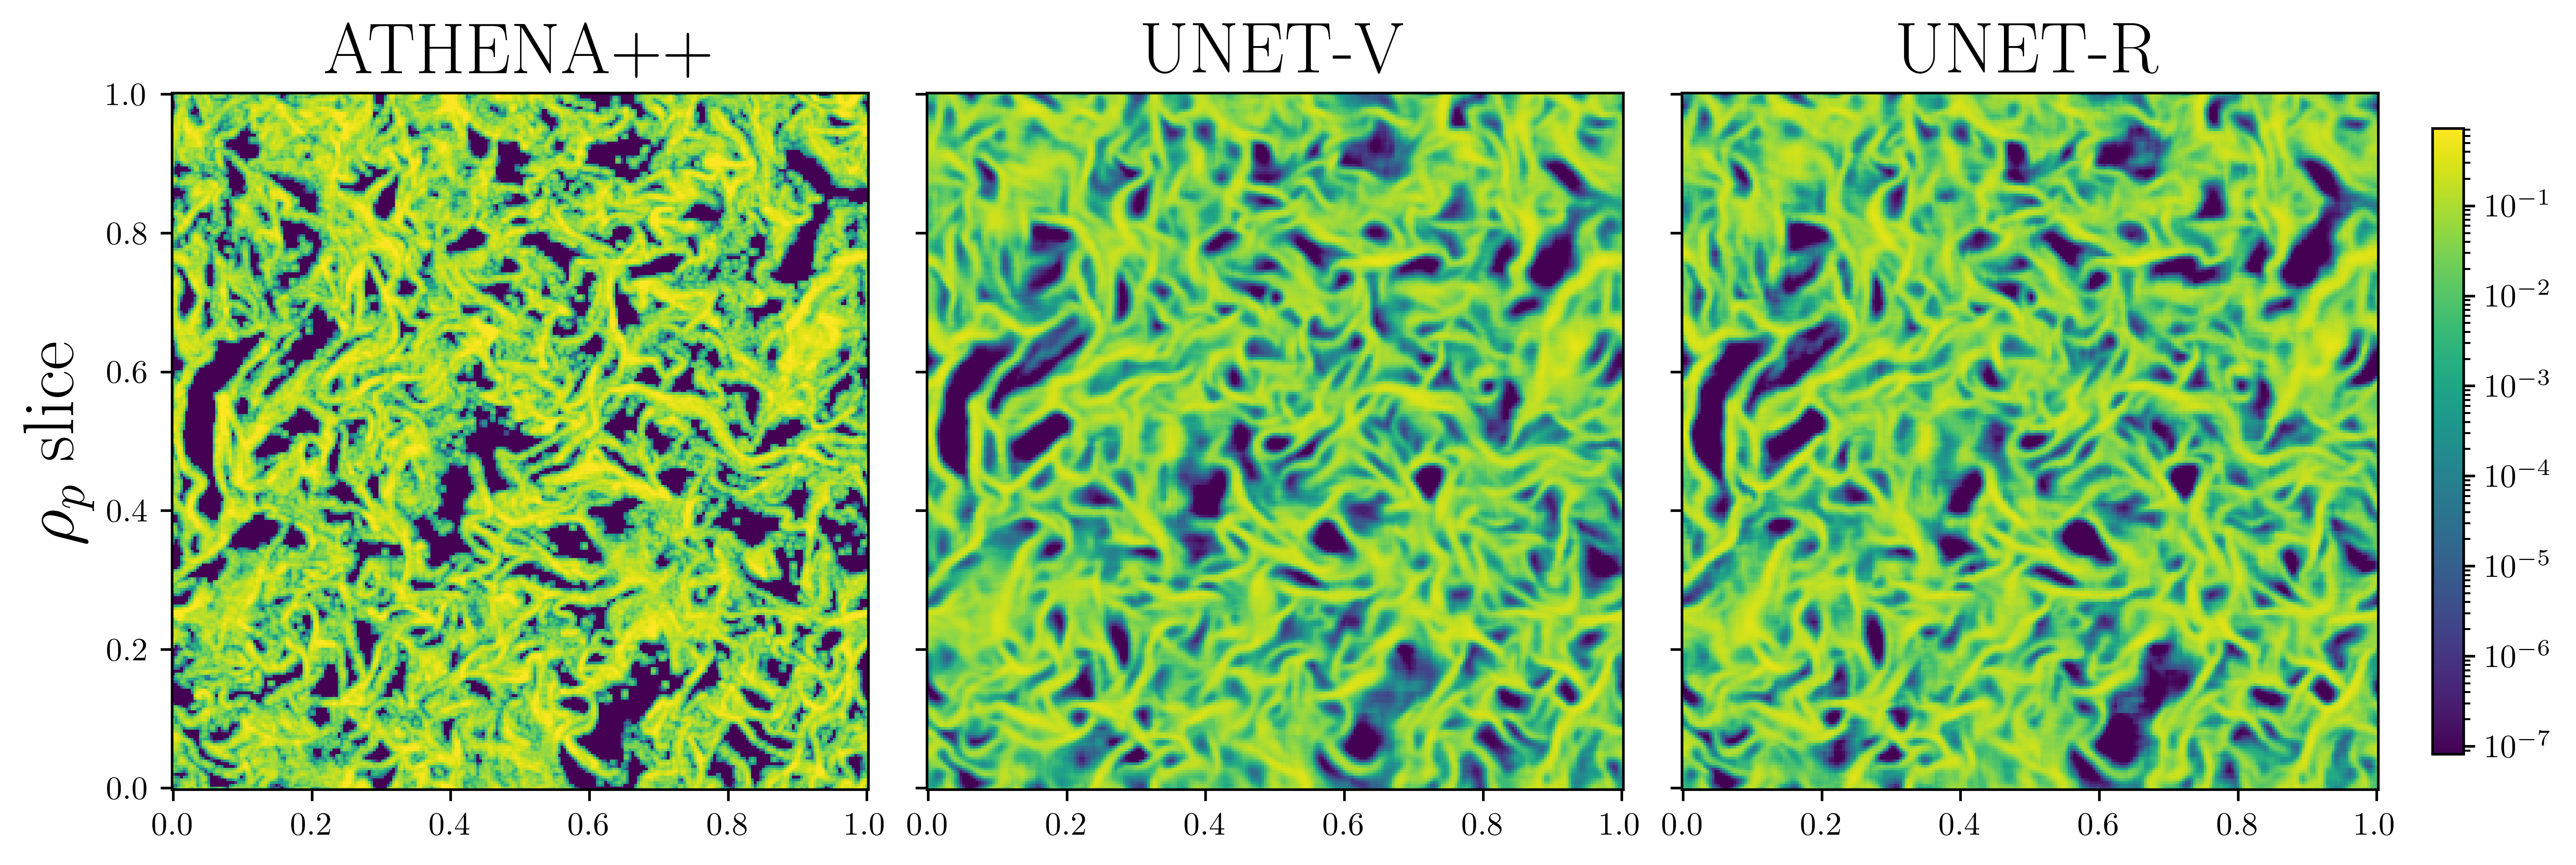

In [10]:
with PdfPages('rhop_slice_comp_normal.pdf') as pdf:
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(10.8,4.5),sharey='row',**plot_params)
    eps,ql,qh,_ = plot_slice(axs[0],tgt_rhop)
    _,_,_,_   = plot_slice(axs[1],unetv_rhop,ql=ql,qh=qh)
    _,_,_, im = plot_slice(axs[2],unetr_rhop,ql=ql,qh=qh)
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    axs[0].set_title('ATHENA++',fontsize=22)
    axs[1].set_title('UNET-V',fontsize=22)
    axs[2].set_title('UNET-R',fontsize=22)
    axs[0].set_ylabel(r'$\rho_p$ slice',fontsize=22)
    fig.colorbar(im, ax=axs[2],shrink=0.6)
    pdf.savefig(fig)

### Cross correlation code

In [ ]:
from numpy.fft import fftn, ifftn, fftshift, fftfreq
from scipy.stats import binned_statistic

In [93]:
#tgt_rhop.shape

In [42]:
def cross_corr(f,g):
    # Compute f*g(tau)
    return np.real(ifftn(fftn(f)*np.conjugate(fftn(g))))

In [95]:
def cross_corr_normed(f,g):
    #print(cross_corr(f,f)[0,0,0],cross_corr(g,g)[0,0,0])
    return cross_corr(f,g)/np.sqrt(cross_corr(f,f)[0,0,0]*cross_corr(g,g)[0,0,0])

In [96]:
athena_athena = cross_corr_normed(tgt_rhop[0],tgt_rhop[0])
athena_unetv = cross_corr_normed(tgt_rhop[0],unetv_rhop[0])
athena_unetr = cross_corr_normed(tgt_rhop[0],unetr_rhop[0])

In [172]:
athena_athena[0,0,0],athena_unetv[0,0,0],athena_unetr[0,0,0]

(1.0, 0.6134356248811292, 0.6221244105652534)

In [97]:
x = fftfreq(256)
y = fftfreq(256)
z = fftfreq(256)

In [98]:
X,Y,Z = np.meshgrid(x,y,z)
R = np.sqrt(X*X+Y*Y+Z*Z)

In [135]:
geom_bins = np.geomspace(1/256,1e0,20)
geom_bins

array([0.00390625, 0.00523009, 0.00700259, 0.0093758 , 0.0125533 ,
       0.01680767, 0.02250385, 0.0301305 , 0.04034185, 0.05401387,
       0.07231939, 0.09682873, 0.12964438, 0.17358139, 0.23240884,
       0.31117315, 0.416631  , 0.55782896, 0.74687948, 1.        ])

In [139]:
athena_athena_binned = binned_statistic(R.flatten(),athena_athena.flatten(),statistic='mean',bins=geom_bins)
athena_unetv_binned  = binned_statistic(R.flatten(),athena_unetv.flatten(),statistic='mean',bins=geom_bins)
athena_unetr_binned  = binned_statistic(R.flatten(),athena_unetr.flatten(),statistic='mean',bins=geom_bins)

In [141]:
athena_athena_cc = np.zeros(len(athena_athena_binned.statistic)+1)
athena_unetv_cc  = np.zeros(len(athena_unetv_binned.statistic)+1)
athena_unetr_cc  = np.zeros(len(athena_unetr_binned.statistic)+1)
athena_athena_cc[1:] = athena_athena_binned.statistic
athena_unetv_cc[1:]  = athena_unetv_binned.statistic
athena_unetr_cc[1:]  = athena_unetr_binned.statistic
athena_athena_cc[0] = athena_athena[0,0,0]
athena_unetv_cc[0] = athena_unetv[0,0,0]
athena_unetr_cc[0] = athena_unetr[0,0,0]

In [155]:
plot_spec = dict(
    nrows=1, ncols=1,
    constrained_layout=True,
    dpi=600,
    figsize=(4.5,4)
)

In [165]:
## Color
mycolors = ['#785EF0', '#DC267F', '#FFB000']

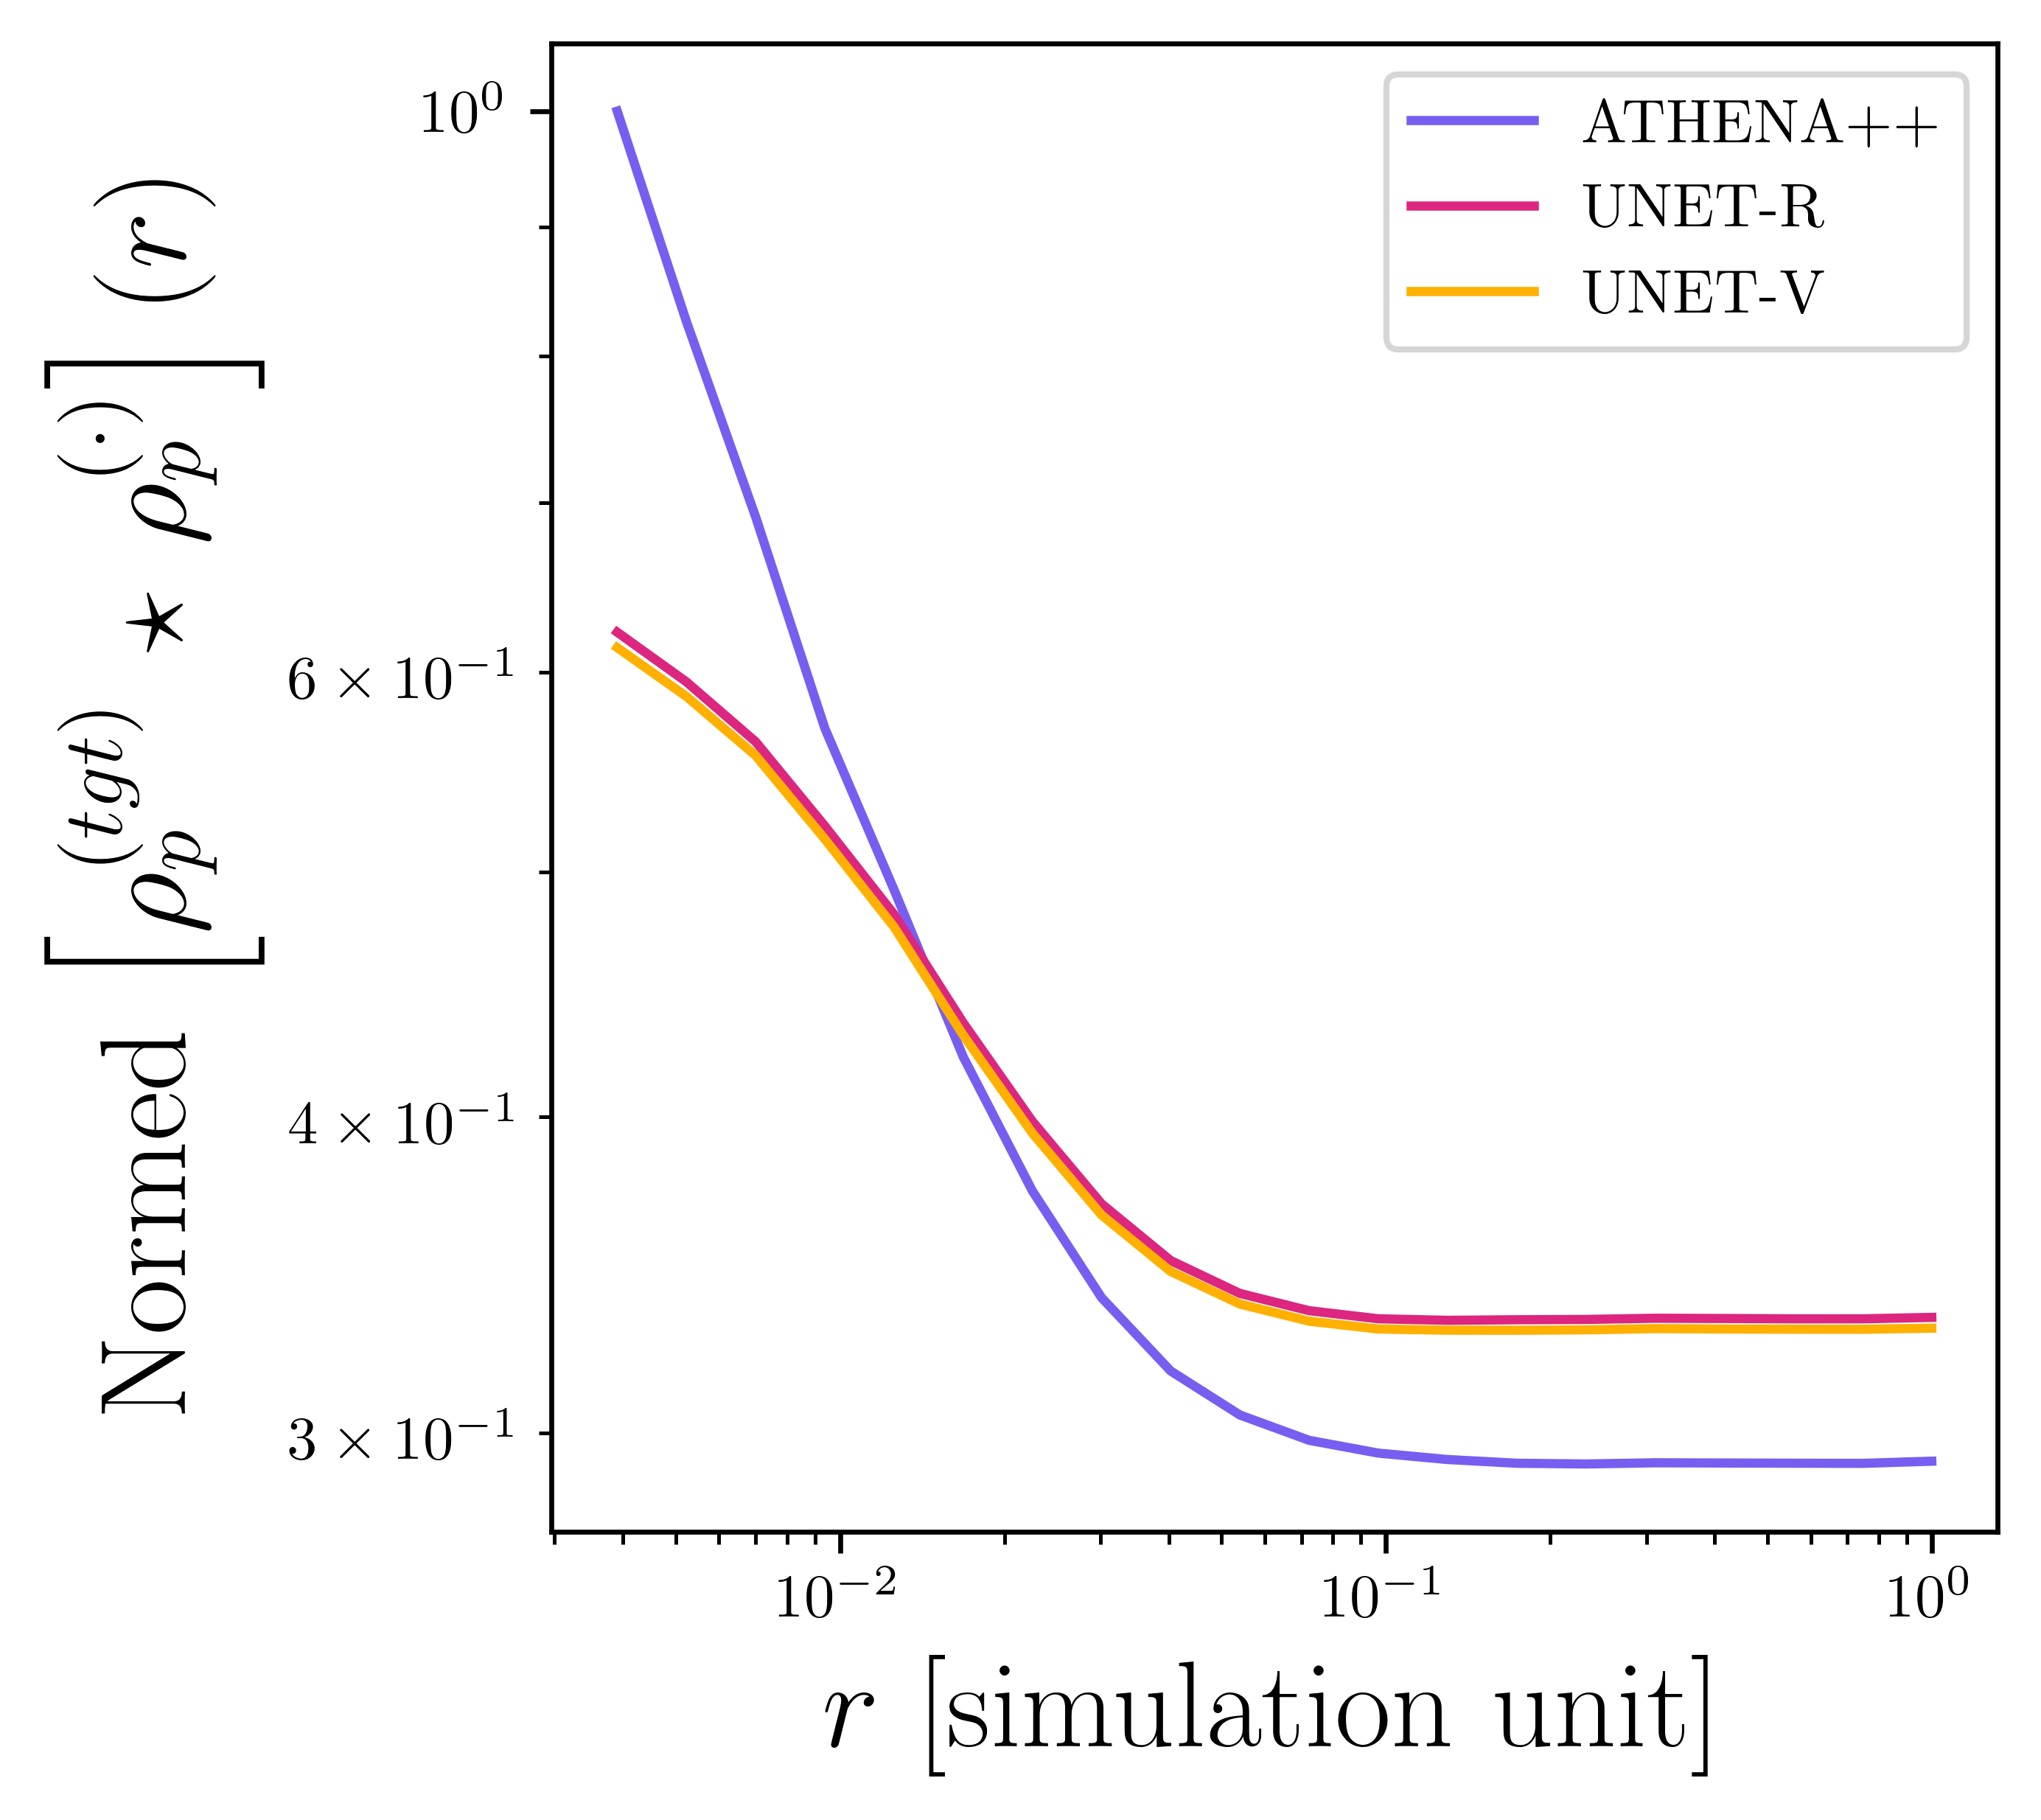

In [174]:
with PdfPages('rhop_cross_corr.pdf') as pdf:
    fig, ax = plt.subplots(**plot_spec)
    ax.loglog(geom_bins,athena_athena_cc,label='ATHENA++',color=mycolors[0])
    ax.loglog(geom_bins,athena_unetr_cc,label='UNET-R',color=mycolors[1])
    ax.loglog(geom_bins,athena_unetv_cc,label='UNET-V',color=mycolors[2])
    ax.set_ylabel(r'Normed $\left[\rho^{(tgt)}_p\,\star\,\rho^{(\cdot)}_p\right](r) $',fontsize=20)
    ax.set_xlabel(r'$r$ [simulation unit]',fontsize=20)
    #plt.ylim(,1)
    ax.legend()
    pdf.savefig(fig)

In [148]:
R.max()

0.8660254037844386

In [104]:
np.sqrt(2)*0.5

0.7071067811865476